<a href="https://colab.research.google.com/github/aemiralfath/BPML-Dicoding/blob/master/Submission_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
import os
import cv2
import sys
import shutil
import pathlib
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import files
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.utils import get_file
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Load Dataset

In [ ]:
! pip install --upgrade --force-reinstall --no-deps kaggle
! mkdir /root/.kaggle/
! cp "/content/drive/My Drive/Machine Learning/kaggle.json" /root/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json

     |████████████████████████████████| 61kB 1.9MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-cp36-none-any.whl size=72859 sha256=0cc91fd34d77e8ec7914b0b6119fa7516b5760a41e3d53ad090a7ea353bf1248
  Stored in directory: /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
Successfully built kaggle
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


In [ ]:
! kaggle datasets download -d mrgeislinger/asl-rgb-depth-fingerspelling-spelling-it-out

 99% 2.10G/2.11G [00:25<00:00, 20.5MB/s]
100% 2.11G/2.11G [00:25<00:00, 89.9MB/s]


In [ ]:
zipref = zipfile.ZipFile('asl-rgb-depth-fingerspelling-spelling-it-out.zip', 'r')
zipref.extractall()
zipref.close()

In [ ]:
base_dir = 'dataset5'
dataset_dir = os.listdir(base_dir)
label_dir = []
for sample_person in dataset_dir:
  label_dir = label_dir + os.listdir(os.path.join(base_dir, sample_person))

label_dir = list(set(label_dir))
dataset_dir.sort()
label_dir.sort()

print('sample person:', dataset_dir)
print('label per sample:', label_dir)

sample person: ['A', 'B', 'C', 'D', 'E']
label per sample: ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y']


In [ ]:
image_train = []
label_train = []

for dir_name in dataset_dir:
  dataset_path = os.path.join(base_dir, dir_name)

  for label_name in os.listdir(dataset_path):
    label_path = os.path.join(dataset_path, label_name)

    for image_name in os.listdir(label_path):
      if image_name.startswith('color_'):
        image_train.append(os.path.join(label_path, image_name))
        label_train.append(label_name)

image_train = np.array(image_train)
label_train = np.array(label_train)
print(image_train.shape)
print(label_train.shape)

(65774,)
(65774,)


In [ ]:
df = pd.DataFrame({'image_path':image_train, 'label':label_train})
df = df.sort_values(by=['image_path'])
df.tail()

,image_path,label
62317,dataset5/E/y/color_24_0518.png,y
62365,dataset5/E/y/color_24_0519.png,y
62282,dataset5/E/y/color_24_0520.png,y
62149,dataset5/E/y/color_24_0521.png,y
62339,dataset5/E/y/color_24_0522.png,y


## Image Resolution

In [ ]:
size_image = []
min_width = sys.maxsize
max_width = 0
min_height = sys.maxsize
max_height = 0

for path in df['image_path']:
  image_name = Image.open(path)
  size_image.append(image_name.size)

  width, height = image_name.size
  if min_width > width:
    min_width = width

  if max_width < width:
    max_width = width

  if min_height > height:
    min_height = height

  if max_height < height:
    max_height = height

size_image = list(set(size_image))
print('resolusi image:', size_image[:10])
print('min width:', min_width)
print('max width:', max_width)
print('min height:', min_height)
print('max height:', max_height)

resolusi image: [(157, 102), (90, 187), (143, 183), (110, 190), (147, 176), (185, 101), (80, 125), (100, 112), (191, 155), (104, 115)]
min width: 64
max width: 249
min height: 64
max height: 272


## Label Size

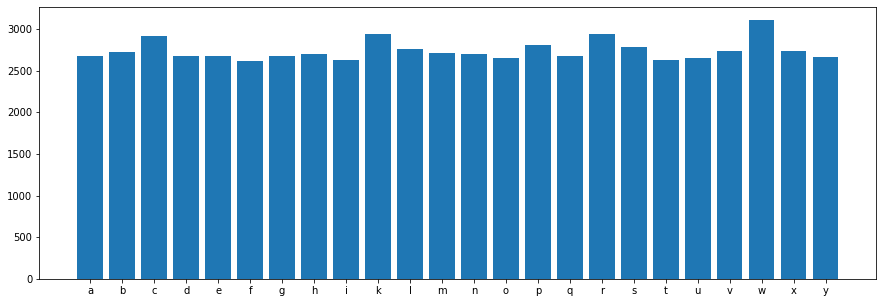

In [ ]:
x, y = np.array([]), np.array([])
min_len = sys.maxsize
for label_name in label_dir:
  data_length = len(df.loc[df['label'] == label_name])
  x = np.append(x, label_name)
  y = np.append(y, data_length)

  if min_len > data_length:
    min_len = data_length

plt.figure(figsize=(15, 5))
plt.bar(x, y)
plt.show()

## Down-sample Minority Class

In [ ]:
df_downsample = pd.DataFrame({'image_path':np.array([]), 'label':np.array([])})
df_test = pd.DataFrame({'image_path':np.array([]), 'label':np.array([])})

for label_name in label_dir:
  data_sample = df.loc[df['label'] == label_name]
  data_downsampled = resample(
      data_sample,
      replace=False,
      n_samples=min_len-15,
      random_state=42
  )

  df_downsample = pd.concat([df_downsample, data_downsampled])

  # sample yang tidak terpakai dijadikan untuk test
  removed_sample = data_sample[~data_sample.apply(tuple, 1).isin(data_downsampled.apply(tuple, 1))]
  df_test = pd.concat([df_test, removed_sample])
  
df_downsample.label.value_counts()

r    2600
i    2600
g    2600
y    2600
q    2600
e    2600
u    2600
b    2600
a    2600
p    2600
c    2600
v    2600
k    2600
n    2600
l    2600
f    2600
m    2600
h    2600
d    2600
o    2600
t    2600
s    2600
w    2600
x    2600
Name: label, dtype: int64

## Preview Image

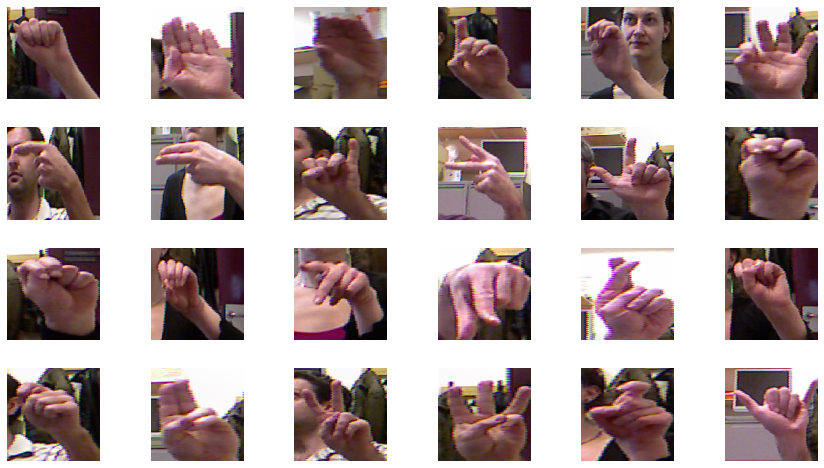

In [ ]:
class ImageViewer:
    def draw_sample_images(self):
      fn = []
      for label_name in label_dir:
        samples = df_downsample[df_downsample['label']==label_name].iloc[0].values
        fn.append(samples[0])

      plt.figure(figsize=(15, 15))
      for n in range(len(fn)):
        plt.subplot(7, 6, n+1)
        plt.subplots_adjust(hspace = 0.3)
        plt.imshow(image.load_img(fn[n], target_size=(128, 128)))
        
        plt.axis('off')
      plt.show()
    
ImageViewer().draw_sample_images()

## Split Image

In [ ]:
train_df = pd.DataFrame({'image_path':np.array([]), 'label':np.array([])})
val_df = pd.DataFrame({'image_path':np.array([]), 'label':np.array([])})

for label_name in label_dir:
  df_sample = df_downsample[df_downsample['label']==label_name]
  train_split, val_split = train_test_split(df_sample, test_size=0.2, random_state=42)
  train_df = pd.concat([train_df, train_split])
  val_df = pd.concat([val_df, val_split])

print('train size:', len(train_df))
print('test size:', len(val_df))

train size: 49920
test size: 12480


## Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=10,
    zoom_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    rescale=1./255
)

In [ ]:
def make_dir(PATH):
  if not os.path.exists(PATH):
      os.mkdir(PATH)
      return PATH
  else:
    shutil.rmtree(PATH)
    os.mkdir(PATH)
    return PATH

## Preview Augmentation

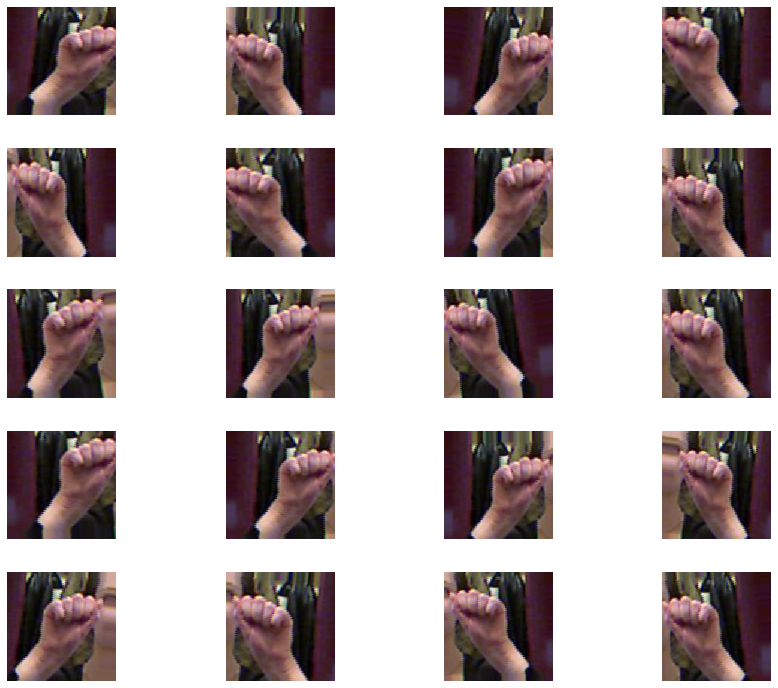

In [ ]:
path_aug = train_df.iloc[1].values[0]
preview_dir = make_dir('/content/preview')

img_augmentation = image.load_img(path_aug)
x_aug = image.img_to_array(img_augmentation)
x_aug = x_aug.reshape((1,) + x_aug.shape)

i = 0
for batch in train_datagen.flow(x_aug, batch_size=1, save_to_dir=preview_dir, save_prefix='sign', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

preview_img = os.listdir(preview_dir)

plt.figure(figsize=(15, 15))
for n in range(len(preview_img)):
  plt.subplot((len(preview_img)/4)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(os.path.join(preview_dir, preview_img[n]),
                            color_mode="rgb",
                            target_size=(150, 150),
                            interpolation="nearest"))
  plt.axis('off')
plt.show()

for fn in preview_img:
  os.system(f'rm {os.path.join(preview_dir, fn)}')

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    batch_size=256,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(128, 128)
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    batch_size=256,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(128, 128)
)

Found 49920 validated image filenames belonging to 24 classes.
Found 12480 validated image filenames belonging to 24 classes.


## Model Sequential

In [ ]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3), activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.MaxPool2D((2, 2)),
                             tf.keras.layers.Dropout(0.25),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.5),
                             tf.keras.layers.Dense(24, activation='softmax')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_4 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_5 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 64)       

In [ ]:
lr = 1e-2
epochs = 10
optimizer = tf.keras.optimizers.Adam(lr=lr)
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

## Callbacks

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', patience=5)

lr_schedule = LearningRateScheduler(
    lambda epoch: lr*10**(epoch)
)

learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_loss', 
    patience = 2,
    verbose = 1,
    factor = 0.25,
    min_lr = 0.0001
)

class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92:
      print("\n Reached 92%, stop training")
      self.model.stop_training = True

callbacks = MyCallback()

## Train

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n//256,
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.n//256,
    callbacks=[earlystopping, learning_rate_reduction, callbacks]  # earlystopping, learning_rate_reduction, callbacks, lr_schedule
) 

Epoch 1/10
195/195 [==============================] - 263s 1s/step - loss: 1.5254 - accuracy: 0.5392 - val_loss: 3.8981 - val_accuracy: 0.2834
Epoch 2/10
195/195 [==============================] - 261s 1s/step - loss: 0.6501 - accuracy: 0.7859 - val_loss: 0.9897 - val_accuracy: 0.7111
Epoch 3/10
195/195 [==============================] - 259s 1s/step - loss: 0.4237 - accuracy: 0.8623 - val_loss: 0.4071 - val_accuracy: 0.8792
Epoch 4/10
195/195 [==============================] - 262s 1s/step - loss: 0.3115 - accuracy: 0.8974 - val_loss: 0.2889 - val_accuracy: 0.9373
Epoch 5/10
195/195 [==============================] - 263s 1s/step - loss: 0.2610 - accuracy: 0.9137 - val_loss: 0.0971 - val_accuracy: 0.9687
Epoch 6/10
195/195 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9254
 Reached 92%, stop training
195/195 [==============================] - 259s 1s/step - loss: 0.2257 - accuracy: 0.9254 - val_loss: 0.1899 - val_accuracy: 0.9416


## Plot

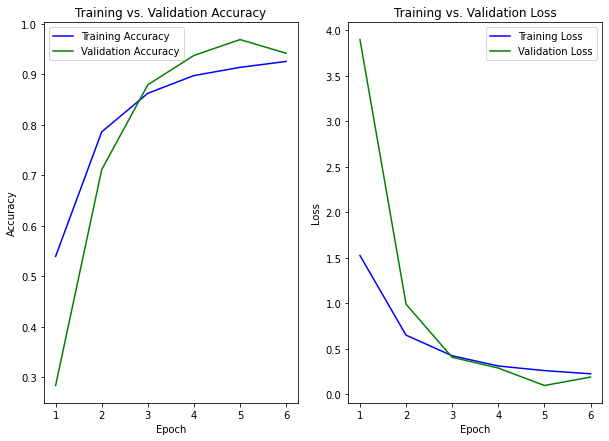

In [ ]:
%matplotlib inline

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([lr, 1e+0, 0, 5])
# plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize = (10, 7))

plt.subplot(1,2,1)
plt.plot(epochs, acc, c = 'b', label = 'Training Accuracy')
plt.plot(epochs, val_acc, c = 'g', label = 'Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, c = 'b', label = 'Training Loss')
plt.plot(epochs, val_loss, c = 'g', label = 'Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
df_test

,image_path,label
7077,dataset5/A/a/color_0_0023.png,a
7080,dataset5/A/a/color_0_0036.png,a
6812,dataset5/A/a/color_0_0132.png,a
7040,dataset5/A/a/color_0_0163.png,a
6787,dataset5/A/a/color_0_0191.png,a
...,...,...
62399,dataset5/E/y/color_24_0292.png,y
62127,dataset5/E/y/color_24_0306.png,y
62447,dataset5/E/y/color_24_0413.png,y
62480,dataset5/E/y/color_24_0415.png,y


In [ ]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    y_col='label',
    batch_size=32,
    color_mode="rgb",
    class_mode="categorical",
    target_size=(128, 128)
)

loss, acc = model.evaluate(test_generator, steps=test_generator.n//32)
print('accuracy test: ',acc)
print('loss test: ',loss)

Found 3374 validated image filenames belonging to 24 classes.
105/105 [==============================] - 4s 39ms/step - loss: 0.1553 - accuracy: 0.9530
accuracy test:  0.9529761672019958
loss test:  0.15526114404201508


## Convert to TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpiio3i8xn/assets


INFO:tensorflow:Assets written to: /tmp/tmpiio3i8xn/assets


In [ ]:
with tf.io.gfile.GFile('model_v1.tflite', 'wb') as f:
  f.write(tflite_model)